In [1]:
#Bi-directional RNN, Momentum, NAG, RMSProp, Dropout 
import theano as th
import theano.tensor as T
import numpy as np
import time
from theano.ifelse import ifelse
from theano.tensor.shared_randomstreams import RandomStreams
from collections import defaultdict

start_time = time.clock()
Data = np.load('prob_t.npz')
Data = Data[Data.files[0]]
F = np.load('TrainID.npz')
TrainID = F[F.files[0]][0]

Label = {}
Y = open('train.lab')
for line in Y:
    line = line.strip().split(',')
    Label[line[0]] = line[1]
Y.close()

#The map from labels to integers(To compute y_hat) 
lab_index = dict([['aa', 0], ['ae', 1], ['ah', 2], ['ao', 3], ['aw', 4], ['ax', 5], ['ay', 6], ['b', 7], ['ch', 8], 
               ['cl', 9], ['d', 10], ['dh', 11], ['dx', 12], ['eh', 13], ['el', 14], ['en', 15], ['epi', 16], 
               ['er', 17], ['ey', 18], ['f', 19], ['g', 20], ['hh', 21], ['ih', 22], ['ix', 23], ['iy', 24], 
               ['jh', 25], ['k', 26], ['l', 27], ['m', 28], ['ng', 29], ['n', 30], ['ow', 31], ['oy', 32], ['p', 33], 
               ['r', 34], ['sh', 35], ['sil', 36], ['s', 37], ['th', 38], ['t', 39], ['uh', 40], ['uw', 41], ['vcl', 42],
               ['v', 43], ['w', 44], ['y', 45], ['zh', 46], ['z', 47]])

def y_hat(i):
    """give the np array of y_hat"""
    l = np.zeros(48,dtype=np.float32)
    l[lab_index[Label[TrainID[i]]]] = 1
    return l

def make_vector_sequence(Data,TID,have_label=True):
    """Concatenate vectors into single sequence of an utterance"""
    Dat = defaultdict(list); Y_hat = defaultdict(list)
    Number = {}; n = 0; old = ''
    for i in range(len(Data)):
        ID = '_'.join(TID[i].split('_')[:2])
        Dat[ID].append(Data[i])
        if have_label:
            Y_hat[ID].append(y_hat(i))
        if ID != old:
            Number[n] = ID
            n += 1
            old = ID
    return Dat, Y_hat, Number

def edit(r,h):
    """edit distance"""
    r = r.split(); h = h.split()
    d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
                if i == 0:
                        d[0][j] = j
                elif j == 0:
                        d[i][0] = i

    for i in range(1, len(r)+1):
            for j in range(1, len(h)+1):
                    if r[i-1] == h[j-1]:
                        d[i][j] = d[i-1][j-1]
                    else:
                        substitution = d[i-1][j-1] + 1
                        insertion    = d[i][j-1] + 1
                        deletion     = d[i-1][j] + 1
                        d[i][j] = min(substitution, insertion, deletion)
    return d[len(r)][len(h)]

TrainX, TrainY, Train_Num =  make_vector_sequence(Data,TrainID)
Order = np.random.permutation(len(Train_Num))

Mapp = open('48_39.map')
mapp = Mapp.readlines()
Mapp.close()

def Map_label(n):
    """Return label an integer(0-47) corresponds to"""
    for key,val in lab_index.items():
        if val == n:
            return key
    print("Worng!")

mapping = {}
for line in mapp:
    line = line.strip().split('\t')
    mapping[line[0]] = line[1]

M = open('48_idx_chr.map_b')
mapp = M.readlines()
M.close()

Map = {}
for line in mapp:
    line = line.strip().split(' ')
    word,_ = line[0].split('\t')
    Map[word] = line[-1]

Yval_cache = {}
def Valid_Y():
    """Return Y_hat of the validation set"""
    try:
        return Yval_cache[0]
    except:
        Val_Y = []
        for i in range(3000,len(Train_Num)):
            yval = ''; last = ''
            for l in TrainY[Train_Num[Order[i]]]:
                phone = Map[mapping[Map_label(np.argmax(l))]]
                if last != phone:
                    yval = yval + phone + ' '
                last = phone
            Val_Y.append(yval[:-1])

        Yval_cache[0] = Val_Y
        return Val_Y

print("Data loaded, using %f seconds"%(time.clock()-start_time))

Data loaded, using 7.246875 seconds


In [31]:
def memo(f): 
    """Memoization decorator, Used to accelerate the retrieval"""
    cache = {}
    def _f(*args):
        try:
            return cache[args]
        except KeyError:
            cache[args] = result = f(*args)
            return result
        except TypeError: #Some elements of args unhashable
            return f(args)
    _f.cache = cache
    return _f

In [6]:
#RNN structure
st = time.clock()
b = 1 #Batch size
learing_rate = 0.00003
srng = RandomStreams(seed=5432)

x_seq = T.fmatrix()
y_hat = T.fmatrix()
ind = T.scalar() #Help to do minibatch
bud = T.scalar() #Help to do Dropout 

cons = 0.001; a=0.0; s=0.01; neuron = 500
a_0 = th.shared(0*np.random.randn(neuron))
Wi = th.shared(0.01*np.random.randn(48,neuron))
bi = th.shared(cons*np.random.randn(neuron)-a)

Wh = th.shared(s*np.identity(neuron)-a)
#Wof = th.shared(0.01*np.random.randn(2*neuron,neuron)-a)
#Wob = th.shared(0.01*np.random.randn(2*neuron,neuron)-a)
bh = th.shared(cons*np.random.randn(neuron)-a)
#bof = th.shared(cons*np.random.randn(neuron)-a)
#bob = th.shared(cons*np.random.randn(neuron)-a)
"""
W2h = th.shared(s*np.identity(neuron)-a)
W2of = th.shared(s*np.concatenate([np.identity(neuron)]*2)-a)
W2ob = th.shared(s*np.concatenate([np.identity(neuron)]*2)-a)
b2h = th.shared(cons*np.random.randn(neuron)-a)
b2of = th.shared(cons*np.random.randn(neuron)-a)
b2ob = th.shared(cons*np.random.randn(neuron)-a)
"""
#W3h = th.shared(s*np.identity(neuron)-a)
W3o = th.shared(0.01*np.random.randn(2*neuron,48))
#b3h = th.shared(cons*np.random.randn(neuron)-a)
b3o = th.shared(cons*np.random.randn(48)-a)

Auxiliary = []; Temp = []
parameters = [Wi,bi,Wh,bh,W3o,b3o]#W2h,W2of,W2ob,b2h,b2of,b2ob,Wof,Wob,bof,bob,W3h,b3h,
for param in parameters:
    Auxiliary.append(th.shared(np.zeros(param.get_value().shape)))
    Temp.append(th.shared(np.zeros(param.get_value().shape)))
    
c = 10
Wi = th.gradient.grad_clip(Wi,-c,c)
bi = th.gradient.grad_clip(bi,-c,c)
Wh = th.gradient.grad_clip(Wh,-c,c)
#Wof = th.gradient.grad_clip(Wof,-c,c)
#Wob = th.gradient.grad_clip(Wob,-c,c)
bh = th.gradient.grad_clip(bh,-c,c)
#bof = th.gradient.grad_clip(bof,-c,c)
#bob = th.gradient.grad_clip(bob,-c,c)
#W3h = th.gradient.grad_clip(W3h,-c,c)
W3o = th.gradient.grad_clip(W3o,-c,c)
#b3h = th.gradient.grad_clip(b3h,-c,c)
b3o = th.gradient.grad_clip(b3o,-c,c)  

def Update_Momentum(para,grad,ind,Momentum,Temp):
    """theano update, optimized by Momentum"""
    updates = []; off_on = ifelse(T.lt(ind,b-1),0,1)
    for ix in range(len(grad)):
        gradient = T.clip(grad[ix],-1,1)#T.clip(grad[ix],np.float32(-0.01),np.float32(0.01))
        direction = (0.95)*Momentum[ix] - (learing_rate/b)*(gradient+Temp[ix])
        updates.append((para[ix], para[ix]+direction*off_on))
        updates.append((Momentum[ix], Momentum[ix]*(1-off_on)+direction*off_on))
        updates.append((Temp[ix], (Temp[ix]+gradient)*(1-off_on)))
    return updates

def Update_NAG(para,grad,ind,Real,Temp):
    """theano update, optimized by NAG"""
    updates = []; off_on = ifelse(T.lt(ind,b-1),0,1)
    for ix in range(len(grad)):
        #grad[ix] = T.clip(grad[ix],-1,1)
        gradient = -(learing_rate/b)*(grad[ix]+Temp[ix])
        spy_position = (1+0.95)*(para[ix]+gradient)-0.95*Real[ix]
        updates.append((para[ix], (spy_position)*off_on+para[ix]*(1-off_on)))
        updates.append((Real[ix], (para[ix]+gradient)*off_on+Real[ix]*(1-off_on)))
        updates.append((Temp[ix], (Temp[ix]+grad[ix])*(1-off_on)))
    return updates

def Update_RMSProp(para,grad,ind,Sigma_square,Temp):
    """theano update, optimized by RMSProp"""
    updates = []; off_on = ifelse(T.lt(ind,b-1),0,1); alpha = 0.9
    for ix in range(len(grad)):
        #grad[ix] = T.clip(grad[ix],-1,1)
        gradient = (grad[ix]+Temp[ix])/b
        Factor = Sigma_square[ix]*alpha+(1-alpha)*gradient**2
        direction = -(learing_rate)*gradient/T.sqrt(Factor)
        updates.append((para[ix], (para[ix]+direction)*off_on+para[ix]*(1-off_on)))
        updates.append((Sigma_square[ix], Factor*off_on+Sigma_square[ix]*(1-off_on)))
        updates.append((Temp[ix], (Temp[ix]+grad[ix])*(1-off_on)))
    return updates

def sigmoid(Z):
    return 1/(1+T.exp(-Z))

def ReLU(Z):
    return T.switch(Z<0,0,Z)

def softmax(Z):
    z = T.exp(Z)
    return (z.T/T.sum(z,axis=1)).T

def step(zf_t,zb_t,af_tm1,ab_tm1):
    af_t = ReLU( zf_t + T.dot(af_tm1,Wh) + bh )
    ab_t = ReLU( zb_t + T.dot(ab_tm1,Wh) + bh )
    return af_t, ab_t

def step2(zf_t,zb_t,af_tm1,ab_tm1):
    af_t = sigmoid( zf_t + T.dot(af_tm1,W2h) + b2h )
    ab_t = sigmoid( zb_t + T.dot(ab_tm1,W2h) + b2h )
    return af_t, ab_t

def step3(zf_t,zb_t,af_tm1,ab_tm1):
    af_t = ReLU( zf_t + T.dot(af_tm1,W3h) + b3h )
    ab_t = ReLU( zb_t + T.dot(ab_tm1,W3h) + b3h )
    return af_t, ab_t

z_seq = T.dot(x_seq,Wi)+bi.dimshuffle('x',0)

[af_seq,ab_seq],_ = th.scan(step, sequences = [z_seq,z_seq[::-1]], 
                               outputs_info = [a_0,a_0],
                              truncate_gradient=-1)
a_out = T.concatenate([af_seq,ab_seq[::-1]],axis=1)
a_seq = ifelse(T.lt(bud,1.05), a_out*srng.binomial(size=T.shape(a_out),p=0.8),a_out)/bud
"""
z1_f = T.dot(a_seq,Wof)+bof.dimshuffle('x',0)
z1_b = T.dot(a_seq,Wob)+bob.dimshuffle('x',0)

[a2f_seq,a2b_seq],_ = th.scan(step3, sequences = [z1_f,z1_b[::-1]], 
                               outputs_info = [a_0,a_0],
                              truncate_gradient=-1)

a2_seq = T.concatenate([a2f_seq,a2b_seq[::-1]],axis=1)
z2_f = T.dot(a2_seq,W2of)+b2of.dimshuffle('x',0)
z2_b = T.dot(a2_seq,W2ob)+b2ob.dimshuffle('x',0)

[a3f_seq,a3b_seq],_ = th.scan(step3, sequences = [z2_f,z2_b[::-1]], 
                               outputs_info = [a_0,a_0],
                              truncate_gradient=-1)

a3_out = T.concatenate([a2f_seq,a2b_seq[::-1]],axis=1)
a3_seq = ifelse(T.lt(bud,1.05), a3_out*srng.binomial(size=T.shape(a3_out),p=0.64),a3_out)/bud
"""
y3_pre = T.dot(a_seq,W3o)+b3o.dimshuffle('x',0)

y_seq = softmax(y3_pre)
forword = th.function(inputs=[x_seq,bud],outputs=y_seq)

cost = (1+ind-ind)*T.sum((y_seq-y_hat)**2)
valid = th.function(inputs=[x_seq,y_hat,ind,bud],outputs=cost)
grads = T.grad(cost,parameters,disconnected_inputs='ignore')
            
rnn_train = th.function(inputs=[x_seq,y_hat,ind,bud],outputs=cost,
                       updates=Update_NAG(parameters,grads,ind,Auxiliary,Temp))

def Validation():
    """Calculate the average edit distance on validation set"""
    Valid_X = []
    for i in range(3000,len(Train_Num)):
        xval = ''; last = ''
        for l in forword(TrainX[Train_Num[Order[i]]],1.2):
            phone = Map[mapping[Map_label(np.argmax(l))]]
            if last != phone:
                xval = xval + phone + ' '
            last = phone
        Valid_X.append(xval[:-1])
        
    Valid_Yhat = Valid_Y()
    return np.mean([edit(Valid_X[i] ,Valid_Yhat[i]) for i in range(len(Valid_X))]).astype(np.float32)

def Valid_Cost():
    """Calculate the cost of the validation set"""
    N = 0;C = 0
    for i in range(3000,len(Train_Num)):
        C += valid(TrainX[Train_Num[Order[i]]],TrainY[Train_Num[Order[i]]],1,1.2)
        N += len(TrainX[Train_Num[Order[i]]])
    return C/N

def Permutate(n):
    """Auxiliary function for making batch of each epoch"""
    s = np.random.permutation(n)
    for i in range(n):
        yield s[i]

print("Model constructed, %f seconds. Start training..."%(time.clock()-st))

Model constructed, 17.012038 seconds. Start training...


In [7]:
Record=[]; Cost = []; Valid_C = []
for j in range(5):
    C = 0; N = 0; batch = 0
    V = Permutate(3600)
    for i in range(3600):
        index = next(V)
        C += rnn_train(TrainX[Train_Num[Order[index]]],TrainY[Train_Num[Order[index]]],batch,1)
        N += len(TrainX[Train_Num[Order[index]]])
        Cost.append(C/N)
        if i%900 == 899:
            Valid_C.append(Valid_Cost())
            print('Cost on last 500 data: %f ; Validation Cost: %f'%(C/N,Valid_C[-1]))
            C = 0; N = 0
            if j > 2:
                val = Validation()
                Record.append(val);
                print("Edit distance on Validation Set: %f" %(val))
                #if len(Record)>1 and Record[-2]+0.5 <= Record[-1]:
                #    break

        batch = batch+1 if batch != (b-1) else 0

    print('%d Epoch(s) trained, %f seconds passed from start.'%((j+1),time.clock()-st))

end = time.clock()
print("Done training. Using %f seconds." % (end-st))

Cost on last 500 data: 0.407321 ; Validation Cost: 0.278923
Cost on last 500 data: 0.279832 ; Validation Cost: 0.264179
Cost on last 500 data: 0.267083 ; Validation Cost: 0.251851
Cost on last 500 data: 0.260132 ; Validation Cost: 0.248456
1 Epoch(s) trained, 3483.669208 seconds passed from start.
Cost on last 500 data: 0.251955 ; Validation Cost: 0.243173
Cost on last 500 data: 0.249092 ; Validation Cost: 0.239458
Cost on last 500 data: 0.248657 ; Validation Cost: 0.236275
Cost on last 500 data: 0.252039 ; Validation Cost: 0.235810
2 Epoch(s) trained, 7001.497495 seconds passed from start.


KeyboardInterrupt: 

In [5]:
#for w in parameters:
#    print(w.get_value()[0])


0.83493310015154232

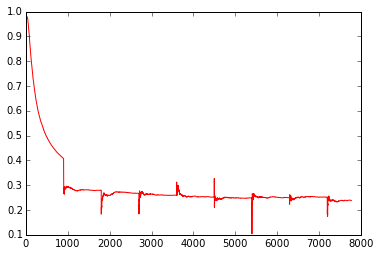

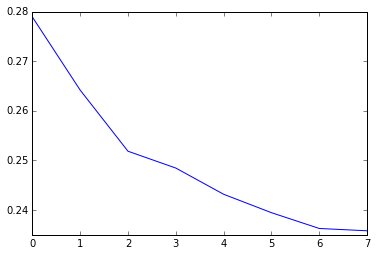

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.plot(Record)
plt.plot(Cost,color='red')
plt.figure()
plt.plot(Valid_C,color='blue')

In [9]:
print("Start predicting...")

Test = np.load('prob.out.npz')
Test = Test[Test.files[0]]
TID = np.load('TestID.npz')
TestID = TID[TID.files[0]][0]

TestD , _ , Test_Num = make_vector_sequence(Test,TestID,False)
Prediction = []
for i in range(len(Test_Num)):
    pre = []
    for l in forword(TestD[Test_Num[i]],1.2):
        pre.append(mapping[Map_label(np.argmax(l))])
    Prediction.append(pre)

def check(L,i):
    if L[i-1] == L[i+1] and L[i] != L[i-1]: #front == behind != me
        return True
    elif L[i]!= L[i+1] and L[i]!= L[i-1]:  # me, front, behind are different 
        return True
    else:
        return False

print("Before sanity check:\n",Prediction[501])

for inde, pred in enumerate(Prediction):
    for i in range(1,len(pred)-1):
        if check(pred,i):
            pred[i] = pred[i-1]
    Prediction[j] = pred

print("After sanity check:\n",Prediction[501])

Start predicting...
Before sanity check:
 ['sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'sil', 'sil', 'sil', 'sil', 't', 't', 't', 't', 'ch', 'ch', 't', 't', 't', 'ah', 'ah', 'ah', 'ah', 'ah', 'n', 'n', 'n', 'n', 'n', 'sil', 'sil', 'sil', 'sil', 'sil', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'l', 'l', 'l', 'l', 'l', 'l', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'ih', 'ih', 'iy', 'n', 'n', 'ng', 'ng', 'sil', 'sil', 'sil', 'sil', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'ah', 'ah', 'ah', 'ah', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'sil', 'sil', 'sil', 'sil', 'sil', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'k',

In [10]:
print("After sanity check:\n",Prediction[4])

After sanity check:
 ['sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'uw', 'uw', 'uw', 'uw', 'uw', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'ih', 'ih', 'ih', 'ih', 'n', 'n', 'n', 'n', 'n', 'n', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'ah', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 'm', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'ow', 'v', 'v', 'v', 'v', 'v', 'v', 'er', 'er', 'er', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'sil', 'sil', 'sil', 'sil', 'sil', 'k', 'k', 'k', 'k', 'k', 'k', 'k', 'ih', 'ih', 'ih', 'ih', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'f', 'f', 'f', '

In [12]:
import csv
csvfile = open('VIRNN500.csv','w',newline='')
write = csv.writer(csvfile, delimiter=',')
write.writerow(['id','phone_sequence'])

for ind, pre in enumerate(Prediction):
    predict = ''; last = ''
    for phone in pre:
        if last != phone:
            predict = predict + Map[phone]
        last = phone
    write.writerow([Test_Num[ind],predict])
    
print("All Done.")

All Done.


<h3 align="center">Testing Ground</h3> 

In [28]:
zzzz = th.shared(3)
xx = T.scalar()
def ff(xx):
    #test()
    return xx

def Up(xx,zzzz):
    test()
    return [(zzzz,zzzz)]
DD = th.function([xx],ff(xx),updates=Up(xx,zzzz))

DD(3)

here


array(3.0)

In [9]:
#Test About Bi-Direction
A = T.matrix()
resu,_ = th.scan(lambda a,b: T.dot(a,b),sequences=[A,A[::-1]])
f = th.function(inputs=[A],outputs=resu)

f([[1,2,3],[9,2,3],[6,2,1],[4,3,0]])

/Users/aaronlai/anaconda/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)


array([ 10.,  61.,  61.,  10.])

In [8]:
#Test about division row by row
A = T.matrix()
B = T.vector()
F = th.function(inputs=[A,B],outputs = (A.T/B).T)

F([[1,2,3],[9,2,3],[6,2,1],[4,3,0]],[2,3,4,5])

array([[ 0.5       ,  1.        ,  1.5       ],
       [ 3.        ,  0.66666667,  1.        ],
       [ 1.5       ,  0.5       ,  0.25      ],
       [ 0.8       ,  0.6       ,  0.        ]])

In [7]:
#Test about tensordot
A = T.tensor3()
B = T.matrix()
c = T.tensordot(A,B,axes=[[2],[0]])

F = th.function(inputs=[A,B],outputs = c)

F([[[3,1,2],[4,2,6]],[[7,2,5],[3,8,1]]],[[-3,0,6,1,2],[2,5,0,-1,3],[1,3,6,5,0]])

array([[[ -5.,  11.,  30.,  12.,   9.],
        [ -2.,  28.,  60.,  32.,  14.]],

       [[-12.,  25.,  72.,  30.,  20.],
        [  8.,  43.,  24.,   0.,  30.]]])

In [6]:
#Test about collect all i-th rows in all matrix to form a new matrix
A = T.tensor3()
B = T.matrix()
c = T.tensordot(A,B,axes=[[2],[0]])

F = th.function(inputs=[A],outputs = A.dimshuffle(1,0,2))

F([[[3,1,2],[4,2,6]],[[7,2,5],[3,8,1]],[[7,2,5],[3,8,1]],[[7,2,5],[3,8,1]]])

array([[[ 3.,  1.,  2.],
        [ 7.,  2.,  5.],
        [ 7.,  2.,  5.],
        [ 7.,  2.,  5.]],

       [[ 4.,  2.,  6.],
        [ 3.,  8.,  1.],
        [ 3.,  8.,  1.],
        [ 3.,  8.,  1.]]])

In [3]:
#Transform DNN's result suitable for counting Edit Distance
import numpy as np
from collections import defaultdict

File = open('Predicts.csv')
Raw = File.readlines()
File.close()
Raw.pop(0)

Data = defaultdict(list)
Number = {}

n = 0; old = ''
for line in Raw:
    ID,cha = line.strip().split(',')
    ID = '_'.join(ID.split('_')[:2])
    Data[ID].append(cha)
    if ID != old:
        Number[n] = ID
        n += 1
        old = ID

print(Data['fjmg0_sx11'], Number[0])
def decide(value,i):
    if value[i-1] == value[i+1]:
        return True
    elif value[i]!= value[i+1]:
        return True
    else:
        return False
    
for key,value in Data.items():
    for i in range(1,len(value)-1):
        if decide(value,i) and value[i]!= value[i-1]:
            value[i] = value[i-1]
    Data[key] = value
    
print(Data['fjmg0_sx11'])

Pre = defaultdict(list)
for key,value in Data.items():
    for v in value:
        if len(Pre[key])==0 or Pre[key][-1]!= v:
            Pre[key].append(v)
            
print(Pre['fjmg0_sx11'])

M = open('48_idx_chr.map_b')
mapp = M.readlines()
M.close()

Map = {}
for line in mapp:
    line = line.strip().split(' ')
    word,_ = line[0].split('\t')
    Map[word] = line[-1]
    
import csv
csvfile = open('V1.csv','w',newline='')
write = csv.writer(csvfile, delimiter=',')
write.writerow(['id','phone_sequence'])

for i in range(len(Number)):
    S = ''
    for word in Pre[Number[i]]:
        S = S + Map[word]
    write.writerow([Number[i],S])
    
print("Done.")

['sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'hh', 'hh', 'hh', 'hh', 'hh', 'hh', 'hh', 'hh', 'hh', 'hh', 'hh', 'iy', 'iy', 'iy', 'iy', 'iy', 'uw', 'uw', 'uw', 'l', 'l', 'w', 'l', 'l', 'l', 'l', 'l', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'aa', 'ah', 'ah', 'ah', 'ah', 'ow', 'ow', 'ow', 'ah', 'ah', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'ae', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aa', 'aw', 'aa', 'aw', 'aw', 'ah', 'aa', 'aa', 'aa', 'aa', 'aa', 'r', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'r', 'r', 'r', 'er', 'er', 'er', 'r', 'ey', 'ey', 'ae', 'ae', 'ae', 'eh', 'eh', 'eh', 'eh', 'eh', 'eh', 'eh', 'eh', 'eh', 'eh', 'eh', 'eh', 'er', 'r', 'er', 'er', 'er', 'er', 'er', 'er', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'aa', 'ay', 'ay', 'ay', 'ay